<a href="https://colab.research.google.com/github/afvallejo/AD_2023/blob/main/2_Filtering_cleaning_and_taging_GEX3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## link Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
!mkdir MyDrive   
!mount --bind /content/drive/My\ Drive /content/MyDrive

## Installing packages

In [ ]:
#%%capture
!pip install rpy2 

In [ ]:
pip install make

In [ ]:
#%%capture
!pip install scanpy[louvain] anndata2ri scrublet loompy 

In [ ]:
#%%capture
%%!
git clone https://github.com/afvallejo/scanpy
cd scanpy
pip install -e .
cd ..

In [ ]:
pip install cellrank

In [ ]:
 pip install llvmlite --ignore-installed

In [ ]:
!conda install -c conda-forge -c bioconda cellrank

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
parallel::detectCores()

In [ ]:
%%time
!Rscript -e "options(Ncpus = 4)" -e "install.packages('BiocManager')" -e "BiocManager::install(c('DropletUtils', 'scater','scRNAseq'))" 

In [ ]:
import os
os.kill(os.getpid(), 9)

## Load packages

In [ ]:
import scanpy as sc

# numpy et al.
import numpy as np
import sys
import scipy as sp
import pandas as pd
import scrublet as scr
import gc
import loompy as lp
import warnings
import scanpy.external as sce

# R integration
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector, FloatVector, ListVector
import rpy2.robjects as ro
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri, numpy2ri, r

import matplotlib
import matplotlib.pyplot as pl

import seaborn as sb
import re
import datetime, time
sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.logging.print_version_and_date()


# R integration
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector, FloatVector, ListVector
import rpy2.robjects as ro
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri, numpy2ri, r
import cellrank as cr

%matplotlib inline

# add extra code to the path
import sys
sys.path.append('/home/jupyter/bucket/sctoolkit/sctoolkit')
from sctransform import sctransform
from proportions import *


from matplotlib import colors
pl.rcParams['pdf.fonttype'] = 'truetype'
sc.set_figure_params(vector_friendly=False,dpi_save=300,transparent=True)
pl.rcParams['lines.linewidth'] = 0.1
sc.set_figure_params(color_map='viridis')
colorsComb = np.vstack([pl.cm.Reds(np.linspace(0, 1, 10)), pl.cm.Greys_r(np.linspace(0.7, 0.8, 0))])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)


cr.logging.print_versions()

Running Scanpy 1.7.2, on 2021-05-23 18:17.


cellrank==1.3.1 scanpy==1.7.2 anndata==0.7.6 numpy==1.19.5 numba==0.51.2 scipy==1.6.3 pandas==1.2.4 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 scvelo==0.2.3 pygam==0.8.0 matplotlib==3.4.2 seaborn==0.11.1


# Setup

## set WD

In [ ]:
%cd /home/jupyter/bucket/AD_Final/KB_cellbender/Kallisto_AD_FINAL/

/home/jupyter/bucket/AD_Final/KB_cellbender/Kallisto_AD_FINAL


In [ ]:
folder='/home/jupyter/bucket/AD_Final/KB_cellbender/Kallisto_AD_FINAL/'

samplename='Gex3'

import os
os.chdir(folder)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

In [ ]:
"""Functions for downstream work with outputs of remove-background."""

import tables
import numpy as np
import scipy.sparse as sp
from typing import Dict


def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.

    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.

    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.

    """

    try:
        import anndata
    except ImportError:
        raise ImportError('The anndata package must be installed to use the '
                          'function anndata_from_h5()')

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    if analyzed_barcodes_only:
        if 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the count matrix.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)})
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # Add other information to the adata object in the appropriate slot.
    for key, value in d.items():
        try:
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == X.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == X.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass

    return adata


def load_anndata_from_input_and_output(input_file: str,
                                       output_file: str,
                                       analyzed_barcodes_only: bool = True,
                                       input_layer_key: str = 'cellranger') -> 'anndata.AnnData':
    """Load remove-background output count matrix into an anndata object,
    together with remove-background metadata and the raw input counts.

    Args:
        input_file: Raw h5 file used as input for remove-background.
        output_file: Output h5 file created by remove-background (can be
            filtered or not).
        analyzed_barcodes_only: Argument passed to anndata_from_h5().
            False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.
        input_layer_key: Key of the anndata.layer that is created for the raw
            input count matrix.

    Return:
        adata_out: AnnData object with counts before and after remove-background,
            as well as inferred latent variables from remove-background.

    """

    # Load input data.
    adata_raw = anndata_from_h5(input_file, analyzed_barcodes_only=False)

    # Load remove-background output data.
    adata_out = anndata_from_h5(output_file, analyzed_barcodes_only=analyzed_barcodes_only)

    # Subset the raw dataset to the relevant barcodes.
    adata_raw = adata_raw[adata_out.obs.index]

    # Put count matrices into 'layers' in anndata for clarity.
    adata_out.layers[input_layer_key] = adata_raw.X.copy()
    adata_out.layers['cellbender'] = adata_out.X.copy()

    # Pre-compute a bit of metadata.
    adata_out.var['n_cellranger'] = np.array(adata_out.layers['cellranger'].sum(axis=0)).squeeze()
    adata_out.var['n_cellbender'] = np.array(adata_out.layers['cellbender'].sum(axis=0)).squeeze()

    return adata_out

In [ ]:
adata = anndata_from_h5('Gex3/cellbender_filtered.h5',analyzed_barcodes_only = True)
adata

AnnData object with n_obs × n_vars = 33371 × 60671
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale'
    var: 'ambient_expression'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [ ]:
adata.obs.index= adata.obs.index.str.replace(r'-1$', '')

In [ ]:
adata.X=adata.layers['spliced']+adata.layers['unspliced']
#adata.X=adata.layers['spliced']
adata.X = sp.sparse.csr_matrix(adata.X)

t2g = pd.read_csv("/home/jupyter/bucket/veloindex/t2g.txt", header=None, names=["tid", "gene_id", "gene_name",'col1','col2','col3','col4'], sep="\t")
t2g.index = t2g.tid
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_id"] = adata.var.index.map(t2g["gene_id"])
adata.var.index = adata.var["gene_id"]
adata.var = adata.var.drop('gene_id', 1)
adata.var_names_make_unique()

/opt/conda/lib/python3.7/site-packages/anndata/utils.py:117: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']


In [ ]:
adata.obs['batch']=['Gex3']*adata.n_obs

 # QC and filtering

In [ ]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

regex = re.compile('^(MT-).*', re.IGNORECASE)
mito_genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1


adata.var['mito'] = False
adata.var.loc[mito_genes, 'mito'] = True
print('Found {} mito genes and annotated.'.format(len(mito_genes)))

sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=True)


adata

Found 0 mito genes and annotated.


AnnData object with n_obs × n_vars = 33371 × 60671
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'ambient_expression', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

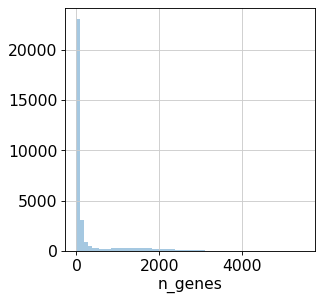

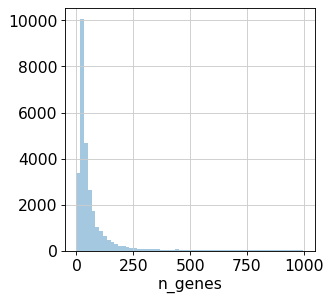

In [ ]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
pl.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
pl.show()

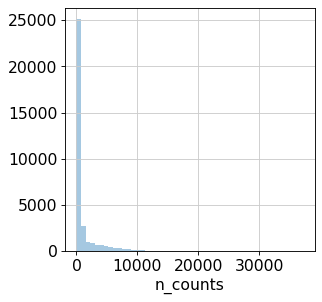

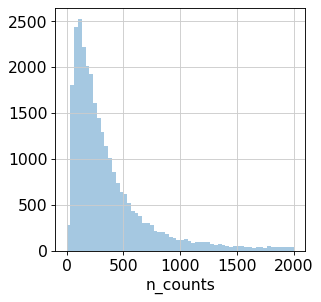

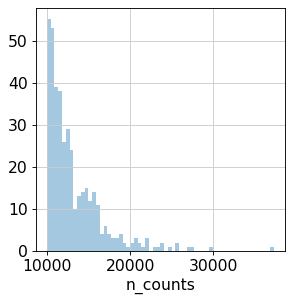

In [ ]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
pl.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<2000], kde=False, bins=60)
pl.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
pl.show()

## Filtering

In [ ]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 200)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 100000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.3]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 100)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

filtered out 11305 cells that have less than 200 counts


Total number of cells: 33371
Number of cells after min count filter: 22066
Number of cells after max count filter: 22066
Number of cells after MT filter: 22066


filtered out 12683 cells that have less than 100 genes expressed
Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 9383


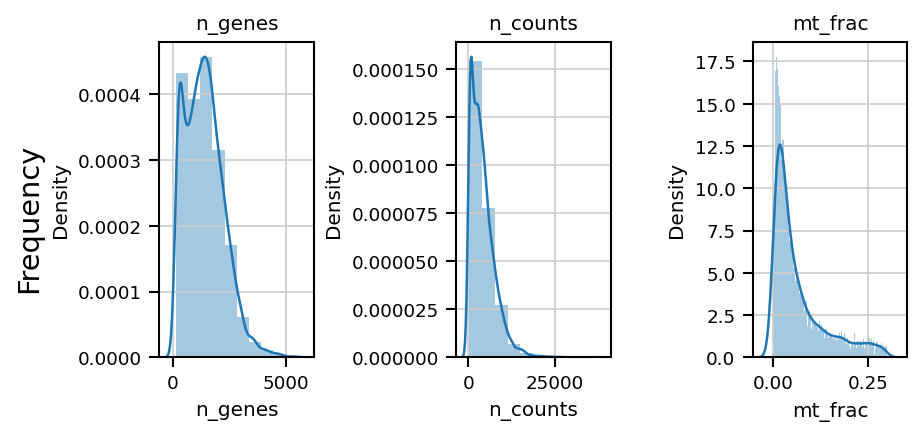

In [ ]:
sb.set_context('paper')

fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharey=False)
adata.obs['n_genes']

sb.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=10)
sb.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=10)
sb.distplot( adata.obs['mt_frac'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('n_genes')
ax2.title.set_text('n_counts')
ax3.title.set_text('mt_frac')

fig.text(0.00, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()
savefig=samplename + '_filtering_panel_postfilter1.pdf'
fig.savefig(savefig, dpi=300, bbox_inches='tight')

Found 37 mito genes and annotated.


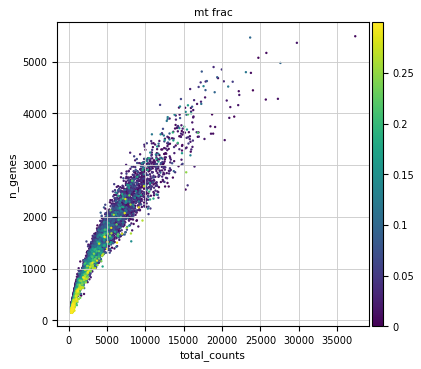

In [ ]:
# plot percentage of mitochondtial genes versus count depth and n_genes
# compute qc metrics
regex = re.compile('^(MT-).*', re.IGNORECASE)
mito_genes = [l for l in adata.var_names for m in [regex.search(l)] if m]
adata.var['mito'] = False
adata.var.loc[mito_genes, 'mito'] = True
print('Found {} mito genes and annotated.'.format(len(mito_genes)))

sc.pp.calculate_qc_metrics(adata, qc_vars=['mito'], inplace=True)

pl.rcParams['figure.figsize']=(5,5) #rescale figures
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='mt_frac',save='.pdf')

In [ ]:
adata.obs

,batch,n_counts,log_counts,n_genes,mt_frac,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito
barcode,,,,,,,,,,,,,,,,
AAACCCACAAATACGA,Gex3,3261.0,8.089789,1302,0.018399,1302,7.172425,3261.0,8.090096,39.558418,46.826127,57.068384,75.406317,60.0,4.110874,1.839926
AAACCCACACCTGCTT,Gex3,13947.0,9.543019,3777,0.008604,3777,8.236950,13947.0,9.543092,23.653832,30.056643,39.047824,55.122966,120.0,4.795791,0.860400
AAACCCACACGATAGG,Gex3,4347.0,8.377241,1870,0.060732,1870,7.534228,4347.0,8.377471,31.677019,39.038417,48.148148,64.665286,264.0,5.579730,6.073154
AAACCCACAGGTGGAT,Gex3,6859.0,8.833317,2019,0.023181,2019,7.610853,6859.0,8.833463,31.258201,40.078729,51.027847,69.266657,159.0,5.075174,2.318122
AAACCCAGTACAGTAA,Gex3,1618.0,7.388946,796,0.014215,796,6.680855,1618.0,7.389564,30.902349,43.263288,58.343634,81.705810,23.0,3.178054,1.421508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGTGATCGG,Gex3,565.0,6.336826,343,0.185841,343,5.840642,565.0,6.338594,48.141593,56.991150,74.690265,100.000000,105.0,4.663439,18.584070
TTTGTTGCACTGGCCA,Gex3,8596.0,9.059052,2213,0.009074,2213,7.702556,8596.0,9.059169,33.480689,42.519777,53.559795,70.812006,78.0,4.369448,0.907399
TTTGTTGCAGACCGCT,Gex3,2680.0,7.893572,1236,0.026119,1236,7.120444,2680.0,7.893945,34.514925,42.574627,53.731343,72.537313,70.0,4.262680,2.611940


In [ ]:
pl.rcParams['figure.figsize']=(3,2)
pl.rcParams['lines.linewidth'] = 0.1

t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=0.5, log=True, cut=0)
t2 = sc.pl.violin(adata, 'n_genes', groupby='sample', size=0.5, log=True, cut=0)
t3 = sc.pl.violin(adata, 'mt_frac', groupby='sample',size=0.5)

normalizing counts per cell
    finished (0:00:00)


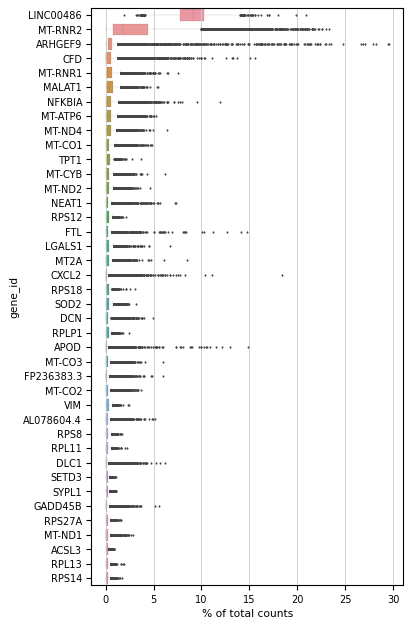

In [ ]:
savefig=samplename + '_highest_expr_genes.pdf'
sc.pl.highest_expr_genes(adata, n_top=40,save=savefig)

In [ ]:
print(adata.obs['sample'].value_counts())

In [ ]:
adata.obs['n_counts'].sum()/adata.obs['sample'].value_counts()

sample1    6292.179905
Name: sample, dtype: float64

In [ ]:
adata.obs['n_counts'].sum()

27238624.0

In [ ]:
adata.var_names_make_unique()

In [ ]:
#sc.pp.downsample_counts(adata, counts_per_cell=180, random_state=0, replace=True)

# Filter doublets with scrublet

In [ ]:
sce.pp.scrublet(adata,
    adata_sim = None,
    sim_doublet_ratio= 2.0,
    expected_doublet_rate = 0.05,
    stdev_doublet_rate = 0.02,
    synthetic_doublet_umi_subsampling= 1.0,
    knn_dist_metric = 'euclidean',
    normalize_variance= True,
    log_transform= False,
    mean_center= True,
    n_prin_comps= 30,
    use_approx_neighbors= True,
    get_doublet_neighbor_parents= False,
    n_neighbors = None,
    threshold = None,
    verbose = True,
    copy= False,
random_state= 0,)

Running Scrublet
filtered out 33412 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    Scrublet finished (0:00:11)


Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 4.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.3%


(<Figure size 640x240 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

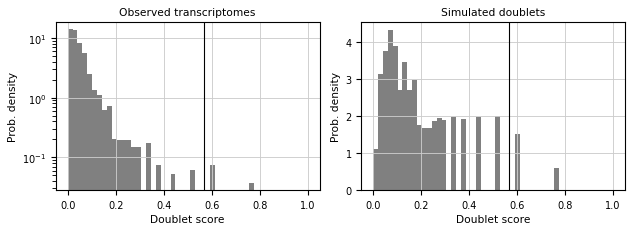

In [ ]:
sce.pl.scrublet_score_distribution(adata)

## remove doublets

In [ ]:
adata2 = adata[adata.obs.predicted_doublet == False]
adata2

View of AnnData object with n_obs × n_vars = 6515 × 60671
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
    layers: 'spliced', 'unspliced'

## Export H5AD

In [ ]:
clean=samplename+"_clean.h5ad"
adata.write(clean)



In [ ]:
clean_Ndoublets=samplename+"_clean_noDoublets.h5ad"
adata2.write(clean_Ndoublets)

# Tagging with HTO

In [ ]:
HTO=sc.read('/home/jupyter/bucket/AD_Final/Aligned/HTO3/counts_unfiltered/adata.h5ad')
HTO

AnnData object with n_obs × n_vars = 3513806 × 10
    var: 'feature_name'

In [ ]:
HTO_clean=HTO[HTO.obs_names.isin(adata.obs.index)].copy()
HTO_clean

AnnData object with n_obs × n_vars = 9383 × 10
    var: 'feature_name'

In [ ]:
clean=samplename+"_clean_HTO.h5ad"
HTO_clean.write(clean)

In [ ]:
adata=adata[adata.obs_names.isin(HTO_clean.obs.index)].copy()
adata

AnnData object with n_obs × n_vars = 9383 × 60671
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'ambient_expression', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

# tagging with hashsolo

In [ ]:
adata=sc.read('Gex3_clean.h5ad')
adata

AnnData object with n_obs × n_vars = 6530 × 60671
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'scrublet'
    layers: 'spliced', 'unspliced'

In [ ]:
HTO=sc.read('Gex3_clean_HTO.h5ad')
HTO

AnnData object with n_obs × n_vars = 9383 × 10
    var: 'feature_name'

In [ ]:
sc.pp.filter_genes(HTO, min_counts=1e4)
HTO.var_names

filtered out 6 genes that are detected in less than 10000.0 counts


Index(['HumanHTO1', 'HumanHTO2', 'HumanHTO3', 'HumanHTO4'], dtype='object', name='feature_id')

In [ ]:
dfdata=pd.DataFrame(HTO.X.toarray(),index=adata.obs.index)
dfdata.columns = ['AD5_C_T_CT',	'AD5_H_T_HT',	'AD12_C_R_CR',	'AD12_H_R_HR']
HTO.obs=dfdata
HTO.obs

,AD5_C_T_CT,AD5_H_T_HT,AD12_C_R_CR,AD12_H_R_HR
barcode,,,,
GAAATGAAGAGATTCA,86.0,97.0,298.0,261.0
GCACTAACACGTAACT,136.0,83.0,113.0,644.0
GAACACTAGTCCTGTA,1005.0,487.0,318.0,703.0
CACCAAAGTACAGAAT,121.0,396.0,154.0,314.0
GCCATTCCAGCTGTGC,122.0,120.0,497.0,1409.0
...,...,...,...,...
TTTCGATCATGGAAGC,113.0,118.0,209.0,294.0
TTCCGTGCAAGTGGCA,51.0,44.0,67.0,180.0
TGGAGGAGTATCAAGA,350.0,87.0,145.0,373.0


In [ ]:
import scanpy.external as sce

In [ ]:
#scanpy.external.pp.hashsolo(adata, cell_hashing_columns, priors=[0.01, 0.8, 0.19], pre_existing_clusters=None, number_of_noise_barcodes=2, inplace=True)
sce.pp.hashsolo(HTO, ['AD5_C_T_CT',	'AD5_H_T_HT',	'AD12_C_R_CR',	'AD12_H_R_HR'])

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


In [ ]:
HTO.obs

,AD5_C_T_CT,AD5_H_T_HT,AD12_C_R_CR,AD12_H_R_HR,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification
barcode,,,,,,,,,,
GAAATGAAGAGATTCA,86.0,97.0,298.0,261.0,1,0,3.980923e-02,0.867919,0.092271,AD12_C_R_CR
GCACTAACACGTAACT,136.0,83.0,113.0,644.0,1,0,6.128496e-05,0.988315,0.011624,AD12_H_R_HR
GAACACTAGTCCTGTA,1005.0,487.0,318.0,703.0,1,0,1.007640e-03,0.722336,0.276656,AD5_C_T_CT
CACCAAAGTACAGAAT,121.0,396.0,154.0,314.0,1,0,2.229602e-02,0.892050,0.085654,AD5_H_T_HT
GCCATTCCAGCTGTGC,122.0,120.0,497.0,1409.0,2,0,3.670030e-08,0.186744,0.813256,Doublet
...,...,...,...,...,...,...,...,...,...,...
TTTCGATCATGGAAGC,113.0,118.0,209.0,294.0,1,0,1.174352e-02,0.963661,0.024595,AD12_H_R_HR
TTCCGTGCAAGTGGCA,51.0,44.0,67.0,180.0,1,0,5.725145e-02,0.942405,0.000344,AD12_H_R_HR
TGGAGGAGTATCAAGA,350.0,87.0,145.0,373.0,2,0,7.034962e-04,0.414408,0.584889,Doublet


In [ ]:
adata.obs['sample'] = HTO.obs['Classification']
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,n_counts,log_counts,n_genes,mt_frac,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,sample
barcode,,,,,,,,,,,,,,,,,,,
GAAATGAAGAGATTCA,7.495728,0.999992,1729.346924,37257.0,10.525595,5475,0.0,5475,8.608130,37257.0,10.525622,24.288053,31.102880,40.631291,56.899375,0.0,0.0,0.0,AD12_C_R_CR
GCACTAACACGTAACT,6.418712,0.999972,1618.234497,29660.0,10.297555,5348,0.0,5348,8.584665,29660.0,10.297588,21.207013,27.737694,37.039784,53.287256,0.0,0.0,0.0,AD12_H_R_HR
GAACACTAGTCCTGTA,6.210265,0.999982,1516.339844,27521.0,10.222705,4961,0.0,4961,8.509564,27521.0,10.222741,32.589659,39.326333,47.941572,61.662004,0.0,0.0,0.0,AD5_C_T_CT
CACCAAAGTACAGAAT,6.258895,0.999971,1483.773682,27170.0,10.209868,4253,0.0,4253,8.355615,27170.0,10.209906,28.251748,36.006625,46.028708,62.432830,0.0,0.0,0.0,AD5_H_T_HT
GCCATTCCAGCTGTGC,5.981774,0.999983,1586.633179,25704.0,10.154402,5164,0.0,5164,8.549660,25704.0,10.154441,34.177560,41.923436,50.447401,62.768441,0.0,0.0,0.0,Doublet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGATCATGGAAGC,0.944909,0.994786,640.825439,204.0,5.318120,121,0.0,121,4.804021,204.0,5.323010,65.196078,89.705882,100.000000,100.000000,0.0,0.0,0.0,AD12_H_R_HR
TTCCGTGCAAGTGGCA,0.930552,0.995897,618.432678,203.0,5.313206,166,0.0,166,5.117994,203.0,5.318120,42.857143,67.487685,100.000000,100.000000,0.0,0.0,0.0,AD12_H_R_HR
TGGAGGAGTATCAAGA,0.803860,0.982980,576.867798,204.0,5.318120,128,0.0,128,4.859812,204.0,5.323010,61.764706,86.274510,100.000000,100.000000,0.0,0.0,0.0,Doublet


In [ ]:
adata.obs['sample'].value_counts()

AD12_H_R_HR    5299
Doublet        1891
AD12_C_R_CR     805
AD5_H_T_HT      725
AD5_C_T_CT      663
Name: sample, dtype: int64

In [ ]:
adata= adata[~adata.obs['sample'].isin(['Doublet','Negative']),:].copy()
adata

AnnData object with n_obs × n_vars = 7492 × 60671
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'sample'
    var: 'ambient_expression', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'contamination_fraction_params', 'fraction_data_used_for_testing', 'lambda_multiplier', 'overdispersion_mean_and_scale', 'target_false_positive_rate', 'test_elbo', 'test_epoch', 'training_elbo_per_epoch'
    obsm: 'latent_gene_encoding'

In [ ]:
clean=samplename+"_clean_taged.h5ad"
adata.write(clean)

... storing 'sample' as categorical


In [ ]:
adata.obs[['Donnor','Treatment','Condition']] = adata.obs['sample'].str.split("_",expand=True,)
adata.obs

In [ ]:
adata.obs['n_counts'].sum()

21628900.0

In [ ]:
panel=['A2M','ABCB1','ABCB11','ABCC2','ABCG2','ABL1','ACOT7','ADA','ADGRE1','ADGRE5','ADGRG3','ADORA2A','AHR','AICDA','AIM2','AIRE','AKT3','ALAS2','ALCAM','AMBP','ANLN','ANP32B','ANP32E','ANXA1','ANXA5','AOC3','APOBEC3G','APOD','APOE','APP','AQP9','ARG1','ARG2','ARL4C','ASF1A','ATAD2','ATF1','ATF2','ATF6B','ATG10','ATG12','ATG16L1','ATG5','ATG7','ATM','AURKA','AURKB','AXL','AZU1','B2M','B3GAT1','BACH2','BATF','BATF3','BAX','BCL10','BCL11B','BCL2','BCL2A1','BCL2L1','BCL6','BID','BIN2','BIRC2','BIRC3','BIRC5','BLK','BLM','BLNK','BMI1','BORA','BPI','BRIP1','BST1','BST2','BTG1','BTK','BTLA','BTN3A1','BTN3A2','BUB1','C1QA','C1QB','C1QBP','C1R','C1S','C2','C3','C3AR1','C4B','C4BPA','C5','C5AR1','C6','C7','C8A','C8B','C8G','C9','CALM3','CAMP','CARD11','CARD9','CASP1','CASP10','CASP3','CASP5','CASP8','CASP8AP2','CBLB','CBX5','CCDC50','CCL1','CCL11','CCL13','CCL14','CCL15','CCL16','CCL17','CCL18','CCL19','CCL2','CCL20','CCL21','CCL22','CCL23','CCL24','CCL25','CCL26','CCL27','CCL28','CCL3','CCL3L1','CCL3L1','CCL4','CCL5','CCL7','CCL8','CCNB1','CCNB2','CCND2','CCND3','CCNE2','CCR1','CCR10','CCR2','CCR3','CCR4','CCR5','CCR6','CCR7','CCR8','CCR9','CCRL2','CD109','CD14','CD160','CD163','CD164','CD180','CD19','CD1A','CD1B','CD1C','CD1D','CD1E','CD2','CD200','CD207','CD209','CD22','CD24','CD244','CD247','CD27','CD274','CD276','CD28','CD300A','CD33','CD34','CD36','CD37','CD38','CD3D','CD3E','CD3G','CD4','CD40','CD40LG','CD44','CD46','CD47','CD48','CD5','CD52','CD53','CD55','CD58','CD59','CD6','CD63','CD68','CD69','CD7','CD70','CD72','CD74','CD79A','CD79B','CD80','CD81','CD83','CD84','CD86','CD8A','CD8B','CD9','CD96','CD99','CDC20','CDC25C','CDC45','CDC6','CDC7','CDCA2','CDCA3','CDCA7','CDCA8','CDH1','CDH5','CDK1','CDK4','CDK6','CDKN1A','CEACAM1','CEACAM6','CEACAM8','CEBPB','CENPA','CENPE','CENPF','CENPU','CES1','CFB','CFD','CFI','CFP','CHAF1B','CHI3L1','CHI3L2','CHIT1','CHST10','CHUK','CIITA','CKAP2','CKAP2L','CKAP5','CKLF','CKS1B','CKS2','CLC','CLEC10A','CLEC2D','CLEC4A','CLEC4C','CLEC4D','CLEC4E','CLEC5A','CLEC6A','CLEC7A','CLSPN','CLU','CMA1','CMKLR1','CMTM2','CMTM6','CNOT2','CNTNAP3','COL3A1','COLEC12','CPA3','CR1','CR2','CREB1','CREB5','CREBBP','CREM','CRP','CRYAB','CSF1','CSF1R','CSF2','CSF2RA','CSF2RB','CSF3','CSF3R','CST7','CTAGE1','CTCF','CTCFL','CTLA4','CTRC','CTSD','CTSG','CTSH','CTSL','CTSS','CTSW','CX3CL1','CX3CR1','CXCL1','CXCL10','CXCL11','CXCL12','CXCL13','CXCL14','CXCL16','CXCL2','CXCL3','CXCL5','CXCL6','CXCL8','CXCL9','CXCR1','CXCR2','CXCR3','CXCR4','CXCR5','CXCR6','CYBB','CYFIP2','CYLD','CYSLTR1','DCN','DCT','DDX43','DDX58','DEFA3','DEFA4','DEFB1','DLGAP5','DLK1','DMBT1','DMKN','DOCK8','DOCK9','DPP4','DSCC1','DTL','DUSP1','DUSP2','DUSP4','DUSP6','E2F8','EBF1','EBI3','ECSIT','ECT2','EDNRB','EED','EGR1','EGR2','EGR3','EHF','ELANE','ELF1','ELF2','ELF4','ELK1','ELK3','ENG','ENTPD1','EOMES','EP300','EPCAM','EPX','ERAL1','ERAP1','ETS1','ETS2','ETV3','ETV6','EWSR1','EXO1','EZH2','F12','F13A1','F2RL1','F5','FABP4','FADD','FAS','FASLG','FBXO22','FCAR','FCER1A','FCER1G','FCER2','FCGR1A','FCGR2A','FCGR2B','FCGR3A','FCGR3B','FCN1','FCRL2','FEN1','FEZ1','FGL2','FICD','FLT3','FLT3LG','FN1','FOS','FOSB','FOSL1','FOXJ1','FOXO1','FOXO3','FOXP1','FOXP3','FPR1','FPR2','FRMD4B','FRYL','FTH1','FUT4','FUT5','FUT7','FYB1','FYN','G2E3','G6PD','GAB2','GABPA','GAGE1','GAS2L3','GATA3','GFI1','GHR','GIMAP2','GIMAP5','GIMAP7','GINS2','GLG1','GMNN','GNAI2','GNG8','GNLY','GPC1','GPI','GRAMD4','GTF3C1','GTSE1','GZMA','GZMB','GZMH','GZMK','GZMM','HAMP','HAVCR1','HAVCR2','HCK','HDC','HELLS','HJURP','HLA-A','HLA-A','HLA-B','HLA-C','HLA-C','HLA-DMA','HLA-DMB','HLA-DOB','HLA-DPA1','HLA-DPB1','HLA-DQA1','HLA-DQA1','HLA-DQB1','HLA-DQB1','HLA-DQB2','HLA-DRA','HLA-DRB1','HLA-DRB1','HLA-DRB1','HLA-DRB1','HLA-DRB5','HLA-E','HLA-F','HLA-G','HMGB1','HMGB2','HMGN3','HMMR','HMOX1','HRAS','HRH4','HSD11B1','ICAM1','ICAM2','ICAM3','ICAM4','ICOS','ICOSLG','IDO1','IER3','IER5','IFI16','IFI27','IFI35','IFIH1','IFIT1','IFIT2','IFITM1','IFITM2','IFITM3','IFNA1','IFNA17','IFNA2','IFNA7','IFNA8','IFNAR1','IFNAR2','IFNB1','IFNG','IFNGR1','IFNGR2','IFNL1','IFNL2','IGBP1','IGF1R','IGF2R','IGLL1','IKBKB','IKBKE','IKBKG','IKZF1','IKZF2','IKZF4','IL10','IL10RA','IL10RB','IL11','IL11RA','IL12A','IL12B','IL12RB1','IL12RB2','IL13','IL13RA1','IL13RA2','IL15','IL15RA','IL16','IL17A','IL17B','IL17F','IL17RA','IL17RB','IL18','IL18R1','IL18RAP','IL19','IL1A','IL1B','IL1R1','IL1R2','IL1RAP','IL1RAPL2','IL1RL1','IL1RL2','IL1RN','IL2','IL21','IL21R','IL22','IL22RA1','IL22RA2','IL23A','IL23R','IL24','IL25','IL26','IL27','IL27RA','IL2RA','IL2RB','IL2RG','IL3','IL31','IL32','IL33','IL34','IL3RA','IL4','IL4I1','IL4R','IL5','IL5RA','IL6','IL6R','IL6ST','IL7','IL7R','IL9','IL9R','ILF3','INPP5D','IRAK1','IRAK2','IRAK4','IRF1','IRF2','IRF3','IRF4','IRF5','IRF7','IRF8','IRGM','ISG15','ISG20','ITCH','ITGA1','ITGA2','ITGA2B','ITGA3','ITGA4','ITGA5','ITGA6','ITGAE','ITGAL','ITGAM','ITGAX','ITGB1','ITGB2','ITGB3','ITGB4','ITGB8','ITK','JAK1','JAK2','JAK3','JAM3','JAML','JCHAIN','JPT1','JUN','JUNB','JUND','KCNE3','KDELR1','KIF11','KIF20B','KIF23','KIF2C','KIR2DL1','KIR2DL3','KIR3DL1','KIR3DL1','KIR3DL2','KIR3DL3','KIT','KLF13','KLF6','KLRB1','KLRC1','KLRC2','KLRC3','KLRC4','KLRD1','KLRF1','KLRG1','KLRK1','KRT1','KRT14','KRT16','KRT17','KRT5','KRT6A','KRTDAP','LAG3','LAIR1','LAIR2','LAMP1','LAMP2','LAMP3','LAP3','LAT','LAT2','LBP','LBR','LCK','LCN2','LCP1','LCP2','LDHA','LEF1','LGALS1','LGALS3','LGALS9','LIF','LILRA1','LILRA4','LILRA5','LILRB1','LILRB1','LILRB2','LILRB3','LILRB4','LIPA','LRBA','LRP1','LRRC3','LRRC32','LRRN3','LTA','LTB','LTBR','LTF','LTK','LUM','LY86','LY9','LY96','LYN','LYVE1','LYZ','MAF','MAGEA1','MAGEA12','MAGEA3','MAGEA4','MAGEB2','MAGEC1','MAGEC2','MALT1','MAP2K1','MAP2K2','MAP2K4','MAP3K1','MAP3K14','MAP3K5','MAP3K7','MAP4K2','MAPK1','MAPK11','MAPK14','MAPK3','MAPK8','MAPKAPK2','MARCO','MASP1','MASP2','MAST4','MAVS','MB21D2','MBL2','MCAM','MCM2','MCM4','MCM5','MCM6','MEF2C','MEFV','MERTK','MFGE8','MGP','MGST1','MICA','MICA','MICB','MIF','MITF','MKI67','MME','MMP12','MMP9','MNX1','MPPED1','MR1','MRC1','MRGPRX2','MS4A1','MS4A2','MS4A4A','MSH2','MSH3','MSH4','MSH5','MSH6','MSR1','MST1R','MUC1','MX1','MYC','MYCL','MYCN','MYD88','MZB1','NAMPT','NASP','NCAM1','NCAPD2','NCF4','NCK1','NCR1','NCR1','NCR3','NDC80','NEFL','NEIL3','NEK2','NFATC1','NFATC2','NFATC3','NFATC4','NFE2L2','NFIL3','NFKB1','NFKB2','NFKBIA','NFKBIZ','NIBAN3','NINJ2','NKG7','NLRC5','NLRP3','NOD1','NOD2','NOS2','NOTCH1','NOTCH2','NOTCH3','NR4A1','NRP1','NT5E','NTRK2','NUF2','NUP107','NUSAP1','OAS1','OAS3','OPTN','OSM','P2RX7','P2RY14','PASD1','PASK','PAX5','PBK','PCLAF','PCNA','PDCD1','PDCD1LG2','PDGFC','PDGFRB','PDIA4','PDIA6','PECAM1','PHF10','PI3','PIK3AP1','PIK3CD','PIK3CG','PIK3IP1','PIMREG','PIN1','PLA2G1B','PLA2G6','PLAT','PLAU','PLAUR','PLEKHG1','PMCH','PMEL','PMP22','PNMA1','PNOC','POLA1','POLD3','POLR1G','POU2AF1','POU2F2','PPARG','PPBP','PRAME','PRDM1','PRF1','PRG2','PRIM1','PRKCD','PRKCE','PRKCQ','PRM1','PSEN1','PSEN2','PSMB10','PSMB7','PSMB8','PSMB9','PSMD7','PSME1','PSRC1','PTAFR','PTGDR2','PTGDS','PTGER4','PTGS2','PTPRC','PTTG2','PVR','PYCARD','PYCR1','QPCT','RAB11FIP1','RAD51','RAD51AP1','RAG1','RANGAP1','RBX1','REL','RELA','RELB','REPS1','RFC2','RGS1','RGS2','RGS5','RHEBL1','RIPK2','RIPOR2','RNASE1','RNASE2','RNASE6','RNF149','RNF207','ROPN1','RORA','RORC','RPA2','RPN2','RRAD','RRM1','RRM2','RUNX1','RUNX3','S100A10','S100A12','S100A2','S100A7','S100A8','S100A9','S100B','S1PR1','S1PR2','SAA1','SBNO2','SDC1','SDHB','SELE','SELL','SELP','SELPLG','SEMA7A','SEMG1','SERPINA1','SERPINB2','SERPINE1','SERPING1','SH2B2','SH2D1A','SH2D1B','SIGIRR','SIGLEC1','SIGLEC5','SIGLEC8','SIRPA','SIRPB1','SIRPG','SIRT1','SKAP1','SLAMF1','SLAMF6','SLAMF7','SLBP','SLC11A1','SLC25A3','SLC25A37','SLC7A7','SMAD2','SMAD3','SMC4','SMCO4','SMPD3','SNCA','SOCS1','SOCS2','SOCS3','SOCS5','SOCS6','SPA17','SPACA3','SPAG1','SPANXB1','SPARCL1','SPATA24','SPATS2L','SPI1','SPIB','SPINK5','SPN','SPO11','SPOCK2','SPP1','SPPL2A','SSX1','ST6GAL1','ST8SIA4','STAT1','STAT2','STAT3','STAT4','STAT5A','STAT5B','STAT6','STING1','SUSD3','SYCP1','SYK','SYT17','TAB1','TACC3','TAGLN','TAL1','TANK','TAP1','TAP2','TAP2','TAPBP','TBK1','TBX21','TCF4','TCF7','TCL1A','TCL1B','TFAM','TFE3','TFEB','TFF3','TFPI','TFRC','TGFB1','TGFB2','TGFB3','TGFBI','THBD','THBS1','THY1','TIAF1','TICAM1','TICAM2','TIFA','TIGIT','TIPIN','TIRAP','TK1','TLR1','TLR10','TLR2','TLR3','TLR4','TLR5','TLR6','TLR7','TLR8','TLR9','TM4SF1','TMEFF2','TMEM97','TMPO','TNF','TNFAIP3','TNFAIP6','TNFRSF10B','TNFRSF10C','TNFRSF11A','TNFRSF11B','TNFRSF12A','TNFRSF13B','TNFRSF13C','TNFRSF14','TNFRSF17','TNFRSF18','TNFRSF1A','TNFRSF1B','TNFRSF25','TNFRSF4','TNFRSF8','TNFRSF9','TNFSF10','TNFSF11','TNFSF12','TNFSF13','TNFSF13B','TNFSF14','TNFSF15','TNFSF18','TNFSF4','TNFSF8','TNFSF9','TNS4','TOLLIP','TOP2A','TOX','TP53','TPSAB1','TPSB2','TPTE','TPX2','TRAF2','TRAF3','TRAF6','TRAT1','TREM1','TREM2','TRGC1','TRIB2','TSPAN32','TTC7A','TTK','TUBB4B','TXK','TXN','TXNIP','TYK2','TYMP','TYMS','TYRP1','UBASH3A','UBE2C','UBE2T','UBE3A','UBR7','UHRF1','ULBP2','UNG','USP1','USP9Y','VAV1','VCAM1','VEGFA','VEGFB','VEGFC','VMO1','VNN2','VPREB3','VPS28','VSIG4','VSIR','VTCN1','WDHD1','WDR76','WT1','XBP1','XCL1','XCL2','XCR1','YBX3','YTHDF2','ZAP70','ZBED2','ZBTB16','ZBTB7B','ZC2HC1A','ZC3H12D','ZNF205','ZNF683']

len(panel)

1177

In [ ]:
print(len(panel))
filter=np.in1d(panel, adata.var_names)
panel = list(np.array(panel)[filter])
print(len(panel))

1177
1174


In [ ]:
adata = adata[:, adata.var_names.isin(panel)] 
adata=adata.copy()
adata.shape

(5229, 1162)

In [ ]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [ ]:
adata.obs['n_counts'].sum()

2297594.0

In [ ]:
2297594*100/21628900


10.622796351178284

In [ ]:
adata.obs['n_counts'].median()

616.0

In [ ]:
100*4406622/32187412

13.690513546103054

In [ ]:
14.262/5.21819

2.7331316031037582